In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import nn
import cv2
import torchvision.transforms as transforms
from cutmix.cutmix import CutMix
from cutmix.utils import CutMixCrossEntropyLoss
from PIL import Image
from tqdm import tqdm
from time import sleep
import numpy as np

# 讀取資料集的路徑以及label

In [4]:
import os

dataset_dir = "./dataset_1200"
class_folder_list = os.listdir(dataset_dir)
#class_folder_list.remove('others')
classes = {}
classes_count = {}
X = []
Y = []
for i, image_class in enumerate(class_folder_list):
    if os.path.isdir(os.path.join(dataset_dir, image_class)):
        classes[image_class] = i
        classes_count[image_class] = len(os.listdir(os.path.join(dataset_dir, image_class)))
        for image_id in os.listdir(os.path.join(dataset_dir, image_class)):
            X.append(image_id)
            Y.append(i)

# 分析資料集類別分佈

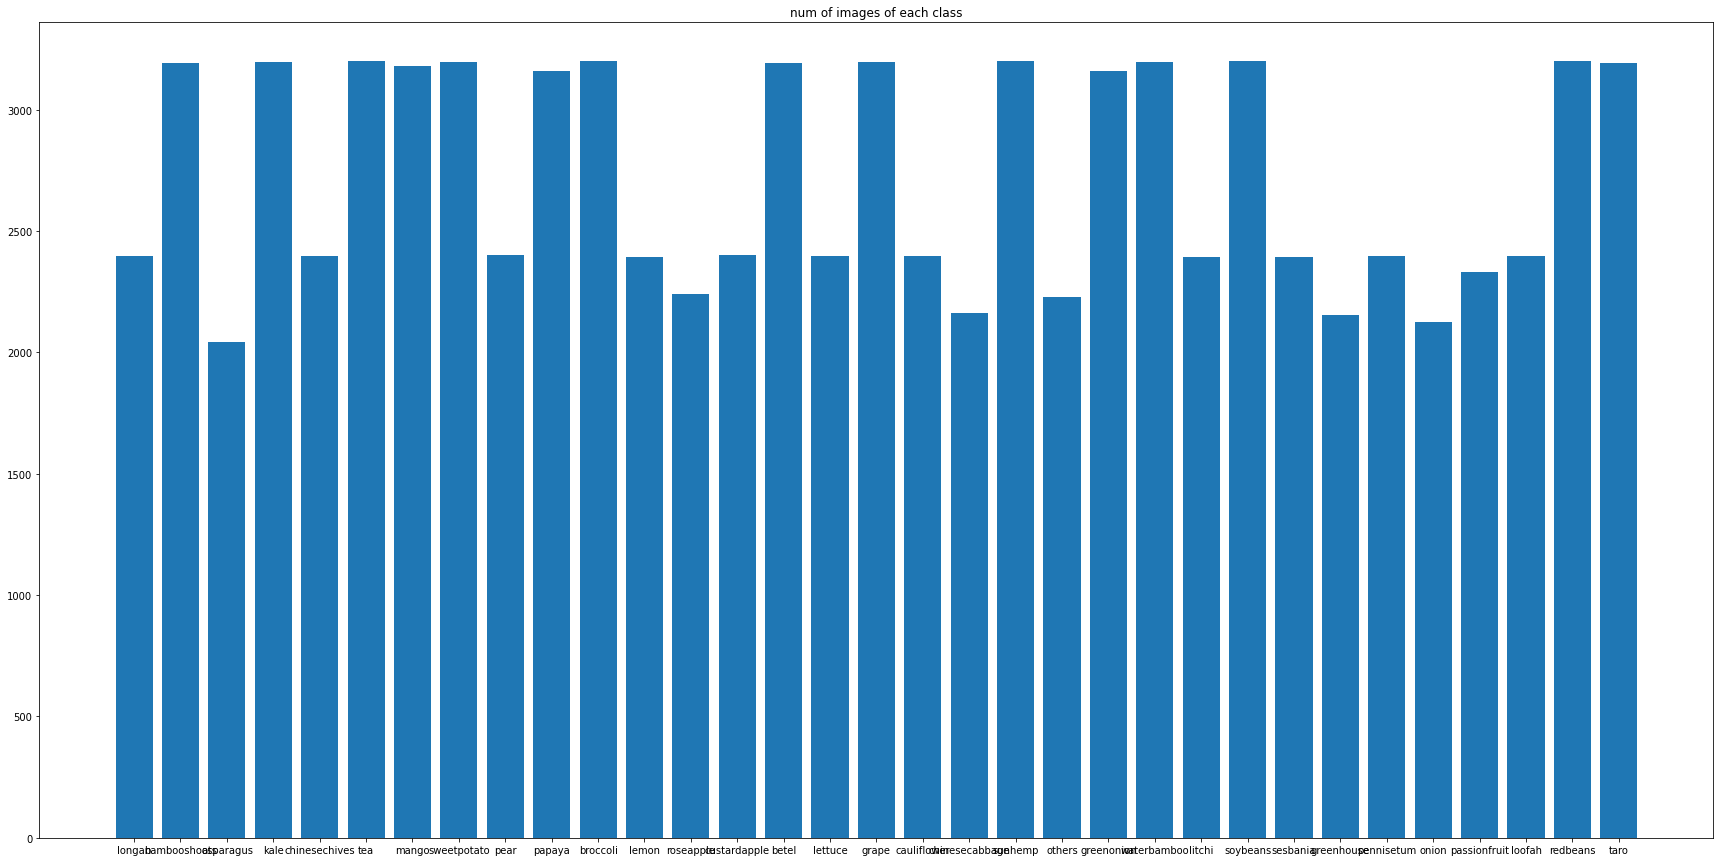

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [30, 15]

ax.bar(classes_count.keys(), classes_count.values())

ax.set_title('num of images of each class')

plt.show()

# 切分訓練集以及驗證集

In [7]:
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val][0]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=77, stratify=Y)

In [9]:
print(len(X_train))
print(len(X_val))

71611
17903


# 宣告Dataset類別

In [10]:
from torch.utils.data import Dataset
import cv2

class CustomDataset(Dataset):
    def __init__(self, img_dir, image_ids, labels, preprocessing=None, augmentation=None):
        self.image_ids = image_ids
        self.labels = labels
        self.img_dir = img_dir
        self.preprocessing = preprocessing
        self.augmentation = augmentation

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, get_keys_from_value(classes, self.labels[idx]), self.image_ids[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.augmentation:
            transformed = self.augmentation(image=image)
            image = transformed["image"]
        if self.preprocessing:
            image = Image.fromarray(image)
            image = self.preprocessing(image)

        return image, label

# 前處理以及Augmentation方法

In [11]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5), #套用水平翻轉
    A.RandomBrightnessContrast(p=0.2), #套用隨機亮度對比度調整
    A.RandomRotate90(p=0.5) #套用隨機90度旋轉
])

preprocessing = transforms.Compose([transforms.Resize([1200, 1200]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.4588, 0.4874, 0.4204],
                                        std=[0.0808, 0.0770, 0.0953])
                    ])

# 讀取預訓練模型

In [12]:
import timm

device = "cuda"
torch.backends.cudnn.benchmark = True
model = timm.create_model('convnext_base_in22ft1k', pretrained=True, num_classes=33)
model = model.to(device)
#將Linear前的Droppout機率設0.5
model.head.drop = nn.Dropout(0.5)
#DP方法，需要多個GPU
model = nn.DataParallel(model)

In [13]:
train_dataset = CustomDataset(dataset_dir, X_train, y_train, preprocessing=preprocessing, augmentation=transform)
train_dataset = CutMix(train_dataset, num_class=33, beta=1.0, prob=0.5, num_mix=2)    # this is paper's original setting for cifar.
val_dataset = CustomDataset(dataset_dir, X_val, y_val, preprocessing=preprocessing)

criterion = CutMixCrossEntropyLoss(True)

epochs = 10
lr = 0.0002828

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler= optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_dataloader))

In [14]:
max_acc = 0
min_loss = 100
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
early_stop = 10
count = 0

for epoch in range(1, epochs+1):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    i = 0

    model.train()
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            target = target.argmax(dim=1)
            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            predictions = output.argmax(dim=1, keepdim=True).squeeze()
            loss = criterion(output, target)
            correct = (predictions == target).sum().item()
            accuracy = correct / 32

            i += 1
            train_loss += loss.item()
            train_acc += accuracy

            loss.backward()

            nn.utils.clip_grad_value_(model.parameters(), 0.1)

            optimizer.step()
            scheduler.step()
            
            tepoch.set_postfix(accuracy=train_acc/i, loss=train_loss/i)
            sleep(0.1)
    train_acc_list.append(train_acc/i)
    train_loss_list.append(train_loss/i)

    i = 0

    model.eval()
    with tqdm(val_dataloader, unit="batch") as tepoch:
        for data, target in tepoch:
            with torch.no_grad():
                tepoch.set_description(f"Epoch {epoch}")

                data, target = data.to(device), target.to(device)
                output = model(data)
                predictions = output.argmax(dim=1).squeeze()
                loss = criterion(output, target)
                correct = (predictions == target).sum().item()
                accuracy = correct / 32

                i += 1
                val_loss += loss.item()
                val_acc += accuracy
                
                tepoch.set_postfix(accuracy=val_acc/i, loss=val_loss/i)
                sleep(0.1)
    val_acc_list.append(val_acc/i)
    val_loss_list.append(val_loss/i)

    if val_loss/i < min_loss:
        min_loss = val_loss/i
        if not os.path.exists('./model/'):
            os.makedirs('./model/')
        torch.save(model, './model/' + 'convnext_base_384_in22ft1k_dropout_cutmix_lrsch_gdc_1200.pth')
        print('Model Saved!')
        count = 0
    else:
        count += 1
    
    if count >= early_stop:
        break

Epoch 1:   0%|          | 0/2238 [00:03<?, ?batch/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
Epoch 1:   6%|▋         | 145/2238 [16:19<3:55:34,  6.75s/batch, accuracy=0.0692, loss=3.46]


KeyboardInterrupt: 

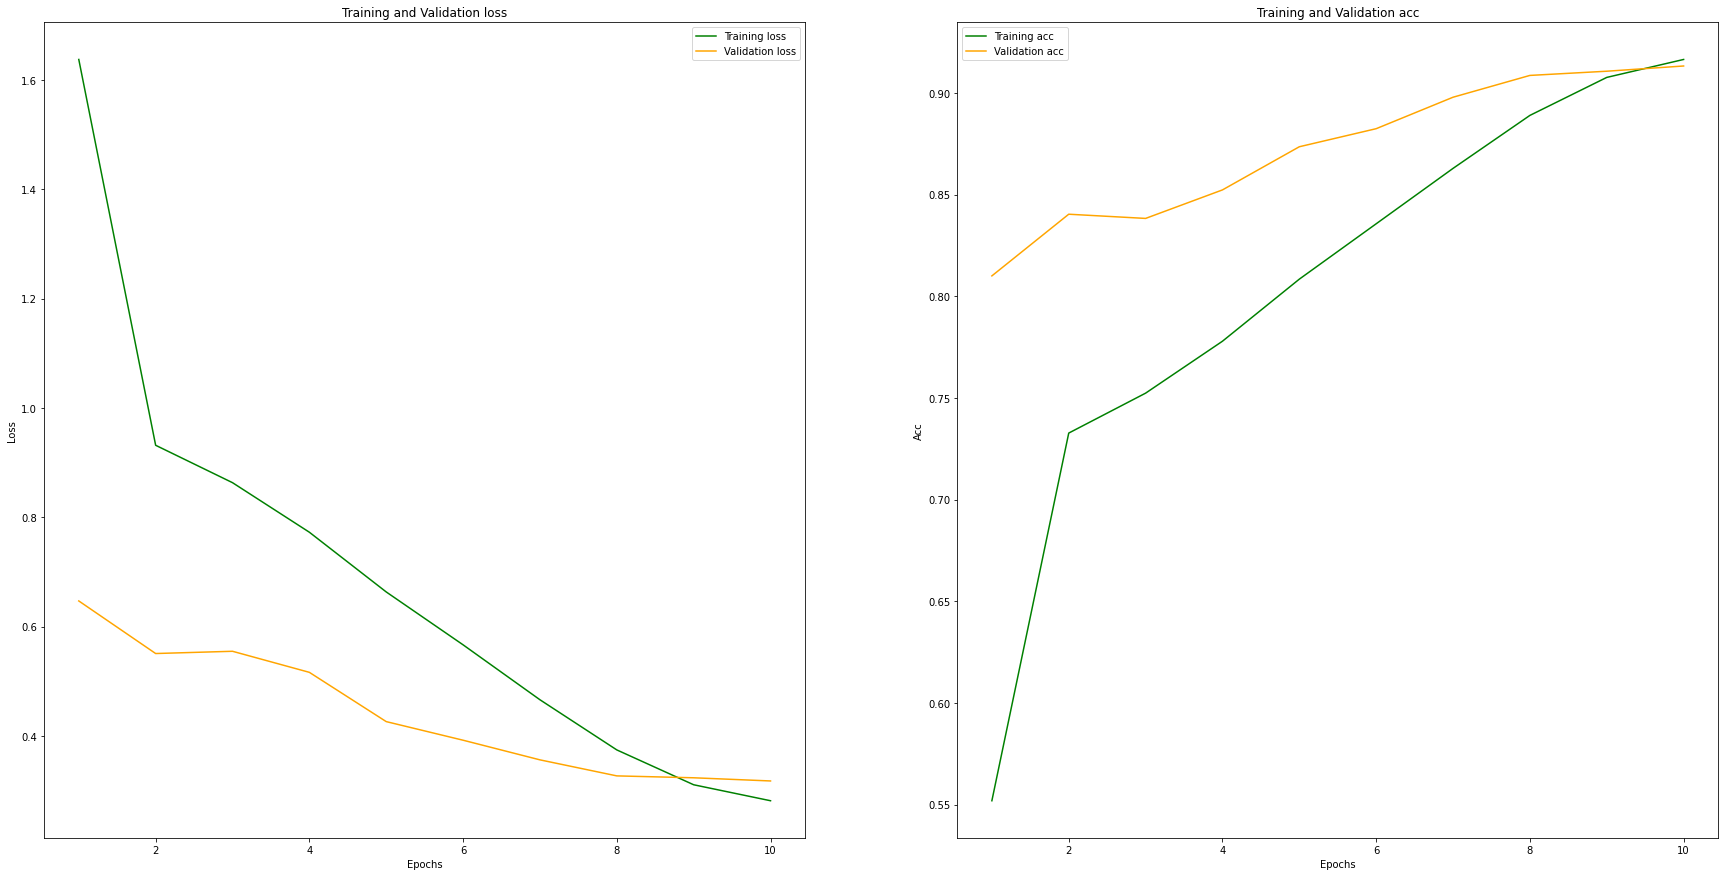

In [138]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_list)+1)

figure, axis = plt.subplots(1, 2)

axis[0].plot(epochs, train_loss_list, 'g', label='Training loss')
axis[0].plot(epochs, val_loss_list, 'orange', label='Validation loss')
axis[0].set_title('Training and Validation loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(epochs, train_acc_list, 'g', label='Training acc')
axis[1].plot(epochs, val_acc_list, 'orange', label='Validation acc')
axis[1].set_title('Training and Validation acc')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Acc')
axis[1].legend()
plt.show()

In [118]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.87056367 0.00626305 0.         ... 0.00417537 0.00208768 0.        ]
 [0.01251956 0.90923318 0.00156495 ... 0.00156495 0.00469484 0.00156495]
 [0.         0.         0.95833333 ... 0.         0.         0.        ]
 ...
 [0.00208333 0.00625    0.         ... 0.90208333 0.00208333 0.00208333]
 [0.         0.         0.         ... 0.0015625  0.96875    0.        ]
 [0.00312989 0.00156495 0.00156495 ... 0.00625978 0.         0.93896714]]


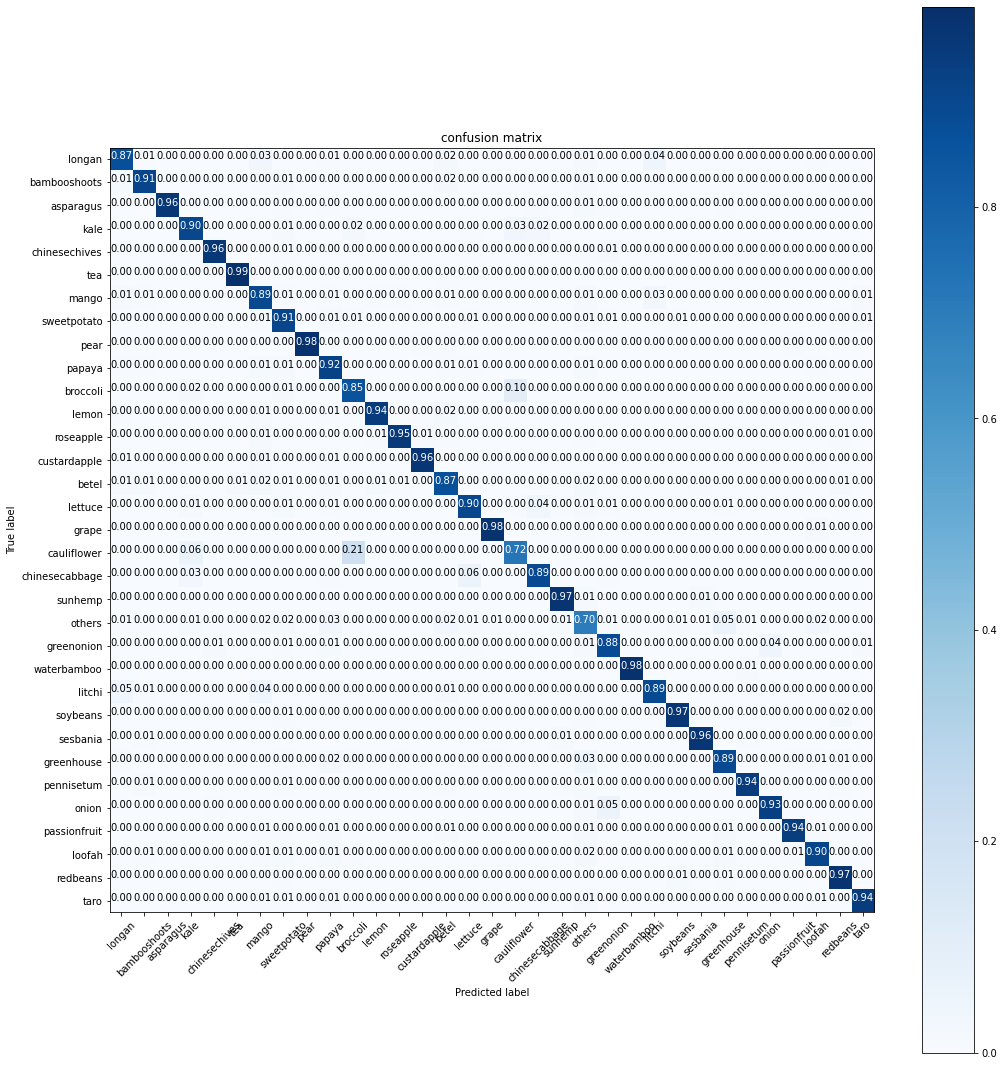

In [148]:
target_names = classes.keys()
plt.rcParams['figure.figsize'] = [20, 20]

plt.figure()
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title='confusion matrix')

plt.show()

# 預測public+private測試集

In [25]:
import pandas as pd

model = torch.load('./model/convnext_base_in22ft1k_dropout_cutmix_lrsch_gdc_1200.pth').to(device)

df = pd.DataFrame(columns=['filename', 'label'])
#設定測試集路徑
test_path = './all_testset_1200/images'

model.eval()
for image_id in tqdm(os.listdir(test_path)):
    with torch.no_grad():
        image = cv2.imread(os.path.join(test_path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = preprocessing(image)
        image = image.unsqueeze(0).to(device)
        output = model(image)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        #將結果紀錄到dataframe
        df = pd.concat([df, pd.DataFrame.from_records([{'filename': image_id, 'label': get_keys_from_value(classes, predictions.item())}])])
        
df.to_csv('./answer_private_convnext_base_1200.csv', index=False)

  0%|          | 0/22308 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 1/22308 [00:00<1:31:58,  4.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 2/22308 [00:00<1:14:12,  5.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 3/22308 [00:00<1:07:25,  5.51it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: Us

  0%|          | 28/22308 [00:04<1:02:19,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 29/22308 [00:04<1:01:29,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 30/22308 [00:05<1:00:00,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 31/22308 [00:05<1:00:00,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  0%|          | 56/22308 [00:09<59:04,  6.28it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 57/22308 [00:09<59:16,  6.26it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 58/22308 [00:09<59:22,  6.25it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|          | 59/22308 [00:09<57:56,  6.40it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py

  1%|          | 112/22308 [00:18<1:01:15,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 113/22308 [00:18<59:55,  6.17it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 114/22308 [00:18<58:52,  6.28it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 115/22308 [00:18<59:57,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  1%|          | 140/22308 [00:22<1:01:25,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 141/22308 [00:23<1:00:21,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 142/22308 [00:23<1:00:17,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 143/22308 [00:23<1:01:07,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  1%|          | 168/22308 [00:27<58:23,  6.32it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 169/22308 [00:27<1:00:07,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 170/22308 [00:27<59:46,  6.17it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 171/22308 [00:27<1:01:18,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter

  1%|          | 196/22308 [00:32<58:14,  6.33it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 197/22308 [00:32<57:18,  6.43it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 198/22308 [00:32<59:00,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 199/22308 [00:32<1:00:58,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gat

  1%|          | 224/22308 [00:36<1:00:09,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 225/22308 [00:36<59:35,  6.18it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 226/22308 [00:36<59:26,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 227/22308 [00:37<59:33,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  1%|          | 252/22308 [00:41<58:16,  6.31it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 253/22308 [00:41<57:48,  6.36it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 254/22308 [00:41<59:20,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|          | 255/22308 [00:41<58:44,  6.26it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gathe

  1%|▏         | 280/22308 [00:45<59:31,  6.17it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|▏         | 281/22308 [00:45<59:02,  6.22it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|▏         | 282/22308 [00:46<58:15,  6.30it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|▏         | 283/22308 [00:46<59:42,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gat

  1%|▏         | 308/22308 [00:50<59:36,  6.15it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|▏         | 309/22308 [00:50<59:45,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|▏         | 310/22308 [00:50<59:33,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  1%|▏         | 311/22308 [00:50<58:56,  6.22it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gat

  2%|▏         | 336/22308 [00:54<57:06,  6.41it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 337/22308 [00:55<56:14,  6.51it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 338/22308 [00:55<57:43,  6.34it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 339/22308 [00:55<56:52,  6.44it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gathe

  2%|▏         | 364/22308 [00:59<59:08,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 365/22308 [00:59<59:11,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 366/22308 [00:59<59:29,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 367/22308 [01:00<1:00:03,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gat

  2%|▏         | 392/22308 [01:04<59:33,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 393/22308 [01:04<1:01:55,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 394/22308 [01:04<1:01:06,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 395/22308 [01:04<1:01:25,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter

  2%|▏         | 420/22308 [01:08<1:08:10,  5.35it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 421/22308 [01:09<1:08:02,  5.36it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 422/22308 [01:09<1:11:07,  5.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 423/22308 [01:09<1:10:16,  5.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  2%|▏         | 448/22308 [01:14<1:02:47,  5.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 449/22308 [01:14<1:04:14,  5.67it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 450/22308 [01:14<1:01:29,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 451/22308 [01:14<1:01:36,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  2%|▏         | 476/22308 [01:19<1:06:37,  5.46it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 477/22308 [01:19<1:03:50,  5.70it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 478/22308 [01:19<1:03:59,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 479/22308 [01:19<1:02:45,  5.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  2%|▏         | 504/22308 [01:23<58:55,  6.17it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 505/22308 [01:24<59:13,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 506/22308 [01:24<59:09,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 507/22308 [01:24<58:15,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gat

  2%|▏         | 532/22308 [01:28<1:01:45,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 533/22308 [01:28<1:01:45,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 534/22308 [01:28<1:01:38,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  2%|▏         | 535/22308 [01:29<1:00:26,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  3%|▎         | 560/22308 [01:33<1:00:59,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 561/22308 [01:33<59:50,  6.06it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 562/22308 [01:33<1:00:04,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 563/22308 [01:33<1:00:17,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  3%|▎         | 588/22308 [01:37<1:01:06,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 589/22308 [01:38<1:02:06,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 590/22308 [01:38<1:01:56,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 591/22308 [01:38<1:00:29,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  3%|▎         | 616/22308 [01:42<1:08:27,  5.28it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 617/22308 [01:42<1:09:52,  5.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 618/22308 [01:43<1:10:00,  5.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 619/22308 [01:43<1:10:43,  5.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  3%|▎         | 644/22308 [01:47<58:48,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 645/22308 [01:48<59:06,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 646/22308 [01:48<58:48,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 647/22308 [01:48<1:00:06,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gat

  3%|▎         | 672/22308 [01:52<59:29,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 673/22308 [01:52<1:01:12,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 674/22308 [01:52<1:01:07,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 675/22308 [01:53<1:01:29,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter

  3%|▎         | 700/22308 [01:57<1:02:11,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 701/22308 [01:57<1:00:34,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 702/22308 [01:57<59:39,  6.04it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 703/22308 [01:58<1:00:36,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  3%|▎         | 728/22308 [02:02<1:01:48,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 729/22308 [02:02<1:01:27,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 730/22308 [02:02<1:01:48,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 731/22308 [02:02<1:01:53,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  3%|▎         | 756/22308 [02:07<1:02:07,  5.78it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 757/22308 [02:07<1:00:00,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 758/22308 [02:07<1:01:11,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  3%|▎         | 759/22308 [02:07<1:02:26,  5.75it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  4%|▎         | 784/22308 [02:12<1:06:50,  5.37it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▎         | 785/22308 [02:12<1:04:18,  5.58it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▎         | 786/22308 [02:12<1:02:58,  5.70it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▎         | 787/22308 [02:12<1:04:12,  5.59it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  4%|▎         | 812/22308 [02:17<1:05:14,  5.49it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▎         | 813/22308 [02:17<1:04:49,  5.53it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▎         | 814/22308 [02:17<1:04:11,  5.58it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▎         | 815/22308 [02:17<1:03:04,  5.68it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  4%|▍         | 840/22308 [02:22<1:03:58,  5.59it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 841/22308 [02:22<1:03:28,  5.64it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 842/22308 [02:22<1:03:34,  5.63it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 843/22308 [02:22<1:02:47,  5.70it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  4%|▍         | 868/22308 [02:27<58:52,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 869/22308 [02:27<58:24,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 870/22308 [02:27<57:54,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 871/22308 [02:27<58:25,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gathe

  4%|▍         | 896/22308 [02:31<57:16,  6.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 897/22308 [02:31<57:11,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 898/22308 [02:32<58:16,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 899/22308 [02:32<58:47,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gathe

  4%|▍         | 924/22308 [02:36<59:09,  6.02it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 925/22308 [02:36<58:34,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 926/22308 [02:36<58:09,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 927/22308 [02:36<58:07,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gat

  4%|▍         | 952/22308 [02:41<1:00:34,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 953/22308 [02:41<1:01:25,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 954/22308 [02:41<1:01:42,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 955/22308 [02:41<1:01:42,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  4%|▍         | 980/22308 [02:46<1:00:00,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 981/22308 [02:46<59:17,  6.00it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 982/22308 [02:46<57:58,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  4%|▍         | 983/22308 [02:46<58:28,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  5%|▍         | 1008/22308 [02:50<59:29,  5.97it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1009/22308 [02:50<58:53,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1010/22308 [02:51<58:04,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1011/22308 [02:51<58:54,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter

  5%|▍         | 1036/22308 [02:55<59:48,  5.93it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1037/22308 [02:55<59:24,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1038/22308 [02:55<59:22,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1039/22308 [02:56<57:58,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter

  5%|▍         | 1064/22308 [03:00<1:00:41,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1065/22308 [03:00<1:01:14,  5.78it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1066/22308 [03:00<1:02:05,  5.70it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1067/22308 [03:00<1:00:07,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

  5%|▍         | 1092/22308 [03:04<57:38,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1093/22308 [03:05<56:51,  6.22it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1094/22308 [03:05<58:46,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▍         | 1095/22308 [03:05<59:31,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  5%|▌         | 1120/22308 [03:09<1:00:13,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1121/22308 [03:09<58:28,  6.04it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1122/22308 [03:09<58:41,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1123/22308 [03:10<57:52,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  5%|▌         | 1148/22308 [03:14<58:26,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1149/22308 [03:14<59:28,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1150/22308 [03:14<59:20,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1151/22308 [03:14<59:27,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  5%|▌         | 1176/22308 [03:19<1:00:45,  5.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1177/22308 [03:19<59:29,  5.92it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1178/22308 [03:19<57:31,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1179/22308 [03:19<57:34,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  5%|▌         | 1204/22308 [03:23<57:57,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1205/22308 [03:24<57:56,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1206/22308 [03:24<58:05,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  5%|▌         | 1207/22308 [03:24<58:05,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  6%|▌         | 1232/22308 [03:28<1:05:50,  5.34it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1233/22308 [03:28<1:04:10,  5.47it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1234/22308 [03:29<1:01:09,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1235/22308 [03:29<1:01:43,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

  6%|▌         | 1260/22308 [03:33<58:34,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1261/22308 [03:33<59:06,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1262/22308 [03:33<58:21,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1263/22308 [03:33<57:08,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  6%|▌         | 1288/22308 [03:38<58:56,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1289/22308 [03:38<59:28,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1290/22308 [03:38<59:29,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1291/22308 [03:38<59:20,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  6%|▌         | 1316/22308 [03:43<59:01,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1317/22308 [03:43<59:32,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1318/22308 [03:43<58:51,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1319/22308 [03:43<58:44,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  6%|▌         | 1344/22308 [03:47<1:01:24,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1345/22308 [03:48<1:00:32,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1346/22308 [03:48<59:43,  5.85it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1347/22308 [03:48<58:10,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/sca

  6%|▌         | 1372/22308 [03:52<1:01:01,  5.72it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1373/22308 [03:52<59:01,  5.91it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1374/22308 [03:53<58:16,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▌         | 1375/22308 [03:53<59:02,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  6%|▋         | 1400/22308 [03:57<58:21,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▋         | 1401/22308 [03:57<58:47,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▋         | 1402/22308 [03:57<57:27,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▋         | 1403/22308 [03:57<57:13,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  6%|▋         | 1428/22308 [04:02<57:47,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▋         | 1429/22308 [04:02<57:23,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▋         | 1430/22308 [04:02<56:55,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  6%|▋         | 1431/22308 [04:02<56:17,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  7%|▋         | 1456/22308 [04:06<1:00:33,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1457/22308 [04:06<59:43,  5.82it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1458/22308 [04:07<58:57,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1459/22308 [04:07<1:01:01,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/sca

  7%|▋         | 1484/22308 [04:11<59:50,  5.80it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1485/22308 [04:11<58:56,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1486/22308 [04:11<59:09,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1487/22308 [04:12<58:53,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter

  7%|▋         | 1512/22308 [04:16<59:39,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1513/22308 [04:16<1:00:48,  5.70it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1514/22308 [04:16<58:47,  5.89it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1515/22308 [04:16<59:36,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

  7%|▋         | 1540/22308 [04:21<57:06,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1541/22308 [04:21<56:43,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1542/22308 [04:21<57:20,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1543/22308 [04:21<58:04,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  7%|▋         | 1568/22308 [04:25<56:55,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1569/22308 [04:26<57:32,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1570/22308 [04:26<58:02,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1571/22308 [04:26<58:29,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  7%|▋         | 1596/22308 [04:31<1:04:45,  5.33it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1597/22308 [04:31<1:03:43,  5.42it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1598/22308 [04:31<1:00:58,  5.66it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1599/22308 [04:31<59:05,  5.84it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

  7%|▋         | 1624/22308 [04:36<57:29,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1625/22308 [04:36<58:39,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1626/22308 [04:36<57:03,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1627/22308 [04:36<57:34,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  7%|▋         | 1652/22308 [04:40<55:45,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1653/22308 [04:40<55:01,  6.26it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1654/22308 [04:41<57:35,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  7%|▋         | 1655/22308 [04:41<57:30,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  8%|▊         | 1680/22308 [04:45<55:11,  6.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1681/22308 [04:45<55:38,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1682/22308 [04:45<55:03,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1683/22308 [04:45<54:38,  6.29it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  8%|▊         | 1708/22308 [04:50<58:37,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1709/22308 [04:50<57:34,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1710/22308 [04:50<58:32,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1711/22308 [04:50<58:59,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  8%|▊         | 1736/22308 [04:54<57:21,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1737/22308 [04:55<57:47,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1738/22308 [04:55<56:52,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1739/22308 [04:55<56:51,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  8%|▊         | 1764/22308 [05:00<1:16:20,  4.49it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1765/22308 [05:00<1:13:35,  4.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1766/22308 [05:00<1:11:21,  4.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1767/22308 [05:01<1:08:54,  4.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

  8%|▊         | 1792/22308 [05:05<1:07:09,  5.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1793/22308 [05:06<1:09:15,  4.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1794/22308 [05:06<1:09:11,  4.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1795/22308 [05:06<1:07:12,  5.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

  8%|▊         | 1820/22308 [05:11<56:57,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1821/22308 [05:11<57:58,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1822/22308 [05:11<57:56,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1823/22308 [05:11<58:36,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  8%|▊         | 1848/22308 [05:15<58:03,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1849/22308 [05:15<56:49,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1850/22308 [05:16<57:44,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1851/22308 [05:16<56:14,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  8%|▊         | 1876/22308 [05:20<57:04,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1877/22308 [05:20<56:38,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1878/22308 [05:20<55:51,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  8%|▊         | 1879/22308 [05:21<55:58,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  9%|▊         | 1904/22308 [05:25<58:11,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▊         | 1905/22308 [05:25<57:01,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▊         | 1906/22308 [05:25<56:29,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▊         | 1907/22308 [05:25<57:09,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  9%|▊         | 1932/22308 [05:30<55:50,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▊         | 1933/22308 [05:30<56:48,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▊         | 1934/22308 [05:30<55:13,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▊         | 1935/22308 [05:30<55:48,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  9%|▉         | 1960/22308 [05:34<56:59,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 1961/22308 [05:35<58:01,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 1962/22308 [05:35<59:03,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 1963/22308 [05:35<57:29,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  9%|▉         | 1988/22308 [05:39<56:15,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 1989/22308 [05:39<54:54,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 1990/22308 [05:39<54:58,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 1991/22308 [05:40<53:45,  6.30it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  9%|▉         | 2016/22308 [05:44<54:19,  6.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2017/22308 [05:44<55:37,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2018/22308 [05:44<53:57,  6.27it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2019/22308 [05:44<52:36,  6.43it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  9%|▉         | 2044/22308 [05:48<54:59,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2045/22308 [05:48<54:24,  6.21it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2046/22308 [05:48<54:46,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2047/22308 [05:49<53:26,  6.32it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  9%|▉         | 2072/22308 [05:53<54:34,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2073/22308 [05:53<57:05,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2074/22308 [05:53<55:55,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2075/22308 [05:53<55:10,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

  9%|▉         | 2100/22308 [05:57<56:45,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2101/22308 [05:58<57:56,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2102/22308 [05:58<57:40,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  9%|▉         | 2103/22308 [05:58<58:53,  5.72it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 10%|▉         | 2128/22308 [06:02<58:01,  5.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2129/22308 [06:02<56:03,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2130/22308 [06:03<57:25,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2131/22308 [06:03<57:23,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 10%|▉         | 2156/22308 [06:07<57:37,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2157/22308 [06:07<57:31,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2158/22308 [06:07<56:32,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2159/22308 [06:07<55:42,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 10%|▉         | 2184/22308 [06:12<57:29,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2185/22308 [06:12<56:56,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2186/22308 [06:12<55:51,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2187/22308 [06:12<57:27,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 10%|▉         | 2212/22308 [06:17<1:05:35,  5.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2213/22308 [06:17<1:06:47,  5.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2214/22308 [06:17<1:05:24,  5.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|▉         | 2215/22308 [06:17<1:07:03,  4.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

 10%|█         | 2240/22308 [06:22<1:04:25,  5.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2241/22308 [06:22<1:04:15,  5.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2242/22308 [06:22<1:05:02,  5.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2243/22308 [06:23<1:04:22,  5.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

 10%|█         | 2268/22308 [06:27<1:00:35,  5.51it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2269/22308 [06:28<58:53,  5.67it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2270/22308 [06:28<59:23,  5.62it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2271/22308 [06:28<59:44,  5.59it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 10%|█         | 2296/22308 [06:32<1:05:03,  5.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2297/22308 [06:33<1:01:36,  5.41it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2298/22308 [06:33<59:11,  5.63it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 10%|█         | 2299/22308 [06:33<59:40,  5.59it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/sca

 10%|█         | 2324/22308 [06:37<56:57,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2802/22308 [08:00<1:02:32,  5.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2803/22308 [08:01<58:57,  5.51it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2804/22308 [08:01<1:01:46,  5.26it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/sca

 13%|█▎        | 2829/22308 [08:05<55:09,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2830/22308 [08:06<53:52,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2831/22308 [08:06<54:25,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2832/22308 [08:06<53:35,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 13%|█▎        | 2857/22308 [08:10<54:43,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2858/22308 [08:10<54:35,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2859/22308 [08:11<53:36,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2860/22308 [08:11<54:27,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 13%|█▎        | 2885/22308 [08:15<53:30,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2886/22308 [08:15<54:56,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2887/22308 [08:15<54:56,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2888/22308 [08:16<54:14,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 13%|█▎        | 2913/22308 [08:20<56:37,  5.71it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2914/22308 [08:20<57:11,  5.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2915/22308 [08:20<56:17,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2916/22308 [08:20<57:23,  5.63it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 13%|█▎        | 2941/22308 [08:25<52:40,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2942/22308 [08:25<51:23,  6.28it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2943/22308 [08:25<53:40,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2944/22308 [08:25<55:56,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 13%|█▎        | 2969/22308 [08:30<55:56,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2970/22308 [08:30<56:58,  5.66it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2971/22308 [08:30<55:48,  5.78it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2972/22308 [08:30<55:56,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 13%|█▎        | 2997/22308 [08:34<56:35,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2998/22308 [08:35<55:59,  5.75it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 2999/22308 [08:35<55:44,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 13%|█▎        | 3000/22308 [08:35<55:04,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 14%|█▎        | 3025/22308 [08:39<52:57,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▎        | 3026/22308 [08:39<53:08,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▎        | 3027/22308 [08:39<53:13,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▎        | 3028/22308 [08:40<53:38,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 14%|█▎        | 3053/22308 [08:44<1:02:34,  5.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▎        | 3054/22308 [08:44<1:02:55,  5.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▎        | 3055/22308 [08:44<1:01:56,  5.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▎        | 3056/22308 [08:44<1:01:05,  5.25it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

 14%|█▍        | 3081/22308 [08:49<53:45,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3082/22308 [08:49<52:30,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3083/22308 [08:49<53:34,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3084/22308 [08:49<54:14,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 14%|█▍        | 3109/22308 [08:54<52:33,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3110/22308 [08:54<52:55,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3111/22308 [08:54<52:29,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3112/22308 [08:54<54:32,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 14%|█▍        | 3137/22308 [08:58<52:32,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3138/22308 [08:59<52:52,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3139/22308 [08:59<53:36,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3140/22308 [08:59<54:16,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 14%|█▍        | 3165/22308 [09:03<57:57,  5.51it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3166/22308 [09:03<55:33,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3167/22308 [09:04<56:54,  5.61it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3168/22308 [09:04<59:00,  5.41it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter

 14%|█▍        | 3193/22308 [09:08<53:00,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3194/22308 [09:08<52:30,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3195/22308 [09:08<53:58,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3196/22308 [09:09<55:12,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 14%|█▍        | 3221/22308 [09:13<56:28,  5.63it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3222/22308 [09:13<55:40,  5.71it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3223/22308 [09:13<55:57,  5.68it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 14%|█▍        | 3224/22308 [09:13<54:37,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 15%|█▍        | 3249/22308 [09:18<52:49,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3250/22308 [09:18<51:44,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3251/22308 [09:18<54:41,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3252/22308 [09:18<55:10,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 15%|█▍        | 3277/22308 [09:22<53:05,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3278/22308 [09:22<52:07,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3279/22308 [09:23<51:37,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3280/22308 [09:23<51:03,  6.21it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 15%|█▍        | 3305/22308 [09:27<50:53,  6.22it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3306/22308 [09:27<51:59,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3307/22308 [09:27<52:40,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3308/22308 [09:27<50:58,  6.21it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 15%|█▍        | 3333/22308 [09:32<53:39,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3334/22308 [09:32<52:12,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3335/22308 [09:32<52:25,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▍        | 3336/22308 [09:32<53:04,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 15%|█▌        | 3361/22308 [09:36<54:23,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3362/22308 [09:37<54:10,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3363/22308 [09:37<54:22,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3364/22308 [09:37<54:22,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 15%|█▌        | 3389/22308 [09:41<53:54,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3390/22308 [09:41<53:54,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3391/22308 [09:41<53:47,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3392/22308 [09:42<53:52,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 15%|█▌        | 3417/22308 [09:46<1:01:03,  5.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3418/22308 [09:47<58:51,  5.35it/s]  /opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3419/22308 [09:47<56:02,  5.62it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3420/22308 [09:47<53:37,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 15%|█▌        | 3445/22308 [09:51<56:03,  5.61it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3446/22308 [09:51<54:20,  5.78it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3447/22308 [09:52<52:48,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 15%|█▌        | 3448/22308 [09:52<52:42,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 16%|█▌        | 3473/22308 [09:56<53:21,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3474/22308 [09:56<53:16,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3475/22308 [09:56<53:12,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3476/22308 [09:56<53:15,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 16%|█▌        | 3501/22308 [10:01<53:46,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3502/22308 [10:01<53:41,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3503/22308 [10:01<52:55,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3504/22308 [10:01<54:07,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 16%|█▌        | 3529/22308 [10:05<54:01,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3530/22308 [10:06<52:37,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3531/22308 [10:06<52:13,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3532/22308 [10:06<51:31,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 16%|█▌        | 3557/22308 [10:10<51:46,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3558/22308 [10:10<51:09,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3559/22308 [10:10<51:52,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3560/22308 [10:11<50:50,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 16%|█▌        | 3585/22308 [10:15<53:05,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3586/22308 [10:15<52:39,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3587/22308 [10:15<50:57,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3588/22308 [10:15<50:34,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 16%|█▌        | 3613/22308 [10:20<55:10,  5.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3614/22308 [10:20<54:42,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3615/22308 [10:20<54:15,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▌        | 3616/22308 [10:20<53:25,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 16%|█▋        | 3641/22308 [10:24<50:06,  6.21it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▋        | 3642/22308 [10:24<51:42,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▋        | 3643/22308 [10:25<50:49,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▋        | 3644/22308 [10:25<51:59,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 16%|█▋        | 3669/22308 [10:29<51:07,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▋        | 3670/22308 [10:29<52:04,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▋        | 3671/22308 [10:29<52:21,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 16%|█▋        | 3672/22308 [10:29<52:10,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 17%|█▋        | 3697/22308 [10:34<52:54,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3698/22308 [10:34<53:48,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3699/22308 [10:34<54:54,  5.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3700/22308 [10:34<53:52,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 17%|█▋        | 3725/22308 [10:39<1:01:22,  5.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3726/22308 [10:39<1:00:20,  5.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3727/22308 [10:39<1:00:11,  5.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3728/22308 [10:40<1:00:43,  5.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/s

 17%|█▋        | 3753/22308 [10:44<54:34,  5.67it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3754/22308 [10:44<53:59,  5.73it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3755/22308 [10:45<53:46,  5.75it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3756/22308 [10:45<53:52,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 17%|█▋        | 3781/22308 [10:49<51:19,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3782/22308 [10:49<51:28,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3783/22308 [10:49<50:36,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3784/22308 [10:50<50:36,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 17%|█▋        | 3809/22308 [10:54<50:34,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3810/22308 [10:54<50:09,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3811/22308 [10:54<54:13,  5.68it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3812/22308 [10:54<53:43,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 17%|█▋        | 3837/22308 [10:58<52:37,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3838/22308 [10:59<51:33,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3839/22308 [10:59<52:17,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3840/22308 [10:59<51:47,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 17%|█▋        | 3865/22308 [11:03<50:33,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3866/22308 [11:03<50:45,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3867/22308 [11:03<50:14,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3868/22308 [11:04<49:19,  6.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 17%|█▋        | 3893/22308 [11:08<50:29,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3894/22308 [11:08<49:47,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3895/22308 [11:08<50:34,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 17%|█▋        | 3896/22308 [11:08<51:39,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 18%|█▊        | 3921/22308 [11:13<51:43,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3922/22308 [11:13<51:45,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3923/22308 [11:13<52:56,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3924/22308 [11:13<51:47,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 18%|█▊        | 3949/22308 [11:17<53:43,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3950/22308 [11:18<51:35,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3951/22308 [11:18<50:49,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3952/22308 [11:18<51:22,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 18%|█▊        | 3977/22308 [11:22<52:36,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3978/22308 [11:22<51:14,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3979/22308 [11:23<50:28,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 3980/22308 [11:23<50:47,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 18%|█▊        | 4005/22308 [11:27<49:43,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4006/22308 [11:27<50:53,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4007/22308 [11:27<52:30,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4008/22308 [11:27<51:22,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 18%|█▊        | 4033/22308 [11:32<50:21,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4034/22308 [11:32<50:26,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4035/22308 [11:32<49:51,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4036/22308 [11:32<50:41,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 18%|█▊        | 4061/22308 [11:36<49:48,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4062/22308 [11:36<49:07,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4063/22308 [11:36<49:03,  6.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4064/22308 [11:37<50:24,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 18%|█▊        | 4089/22308 [11:41<50:22,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4090/22308 [11:41<51:09,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4091/22308 [11:41<51:04,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4092/22308 [11:41<51:47,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 18%|█▊        | 4117/22308 [11:46<51:14,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4118/22308 [11:46<52:37,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4119/22308 [11:46<51:32,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 18%|█▊        | 4120/22308 [11:46<50:48,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 19%|█▊        | 4145/22308 [11:50<50:30,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▊        | 4146/22308 [11:50<50:30,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▊        | 4147/22308 [11:51<51:27,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▊        | 4148/22308 [11:51<49:57,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 19%|█▊        | 4173/22308 [11:55<50:20,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▊        | 4174/22308 [11:55<50:47,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▊        | 4175/22308 [11:55<51:21,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▊        | 4176/22308 [11:56<1:03:49,  4.73it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter

 19%|█▉        | 4201/22308 [12:00<49:18,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4202/22308 [12:00<49:50,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4203/22308 [12:00<50:41,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4204/22308 [12:00<50:46,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 19%|█▉        | 4229/22308 [12:04<51:14,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4230/22308 [12:05<51:07,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4231/22308 [12:05<52:23,  5.75it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4232/22308 [12:05<53:11,  5.66it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 19%|█▉        | 4257/22308 [12:09<49:05,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4258/22308 [12:09<50:00,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4259/22308 [12:09<49:08,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4260/22308 [12:10<48:10,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 19%|█▉        | 4285/22308 [12:14<51:41,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4286/22308 [12:14<50:29,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4287/22308 [12:14<49:59,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 19%|█▉        | 4288/22308 [12:14<49:26,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_g

 19%|█▉        | 4313/22308 [12:18<50:58,  5.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 49%|████▉     | 10880/22308 [30:57<31:20,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10881/22308 [30:57<31:47,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10882/22308 [30:

 49%|████▉     | 10907/22308 [31:01<36:52,  5.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10908/22308 [31:02<37:45,  5.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10909/22308 [31:02<36:50,  5.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10910/22308 [31:02<37:11,  5.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 49%|████▉     | 10935/22308 [31:06<32:51,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10936/22308 [31:07<33:22,  5.68it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10937/22308 [31:07<32:59,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10938/22308 [31:07<33:00,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 49%|████▉     | 10963/22308 [31:11<31:33,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10964/22308 [31:11<31:27,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10965/22308 [31:12<31:46,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10966/22308 [31:12<31:04,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 49%|████▉     | 10991/22308 [31:16<31:47,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10992/22308 [31:16<31:04,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10993/22308 [31:16<31:15,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 10994/22308 [31:16<30:51,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 49%|████▉     | 11019/22308 [31:21<30:36,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 11020/22308 [31:21<30:32,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 11021/22308 [31:21<31:04,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 49%|████▉     | 11022/22308 [31:21<31:32,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 50%|████▉     | 11047/22308 [31:25<32:32,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11048/22308 [31:25<32:29,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11049/22308 [31:26<32:27,  5.78it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11050/22308 [31:26<32:27,  5.78it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 50%|████▉     | 11075/22308 [31:30<31:36,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11076/22308 [31:30<31:28,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11077/22308 [31:30<31:14,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11078/22308 [31:30<30:47,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 50%|████▉     | 11103/22308 [31:35<32:31,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11104/22308 [31:35<31:25,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11105/22308 [31:35<31:29,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11106/22308 [31:35<31:35,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 50%|████▉     | 11131/22308 [31:39<31:11,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11132/22308 [31:40<31:27,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11133/22308 [31:40<30:58,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|████▉     | 11134/22308 [31:40<31:46,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 50%|█████     | 11159/22308 [31:44<31:15,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11160/22308 [31:44<31:41,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11161/22308 [31:44<33:03,  5.62it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11162/22308 [31:45<33:43,  5.51it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 50%|█████     | 11187/22308 [31:49<30:58,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11188/22308 [31:49<31:47,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11189/22308 [31:49<31:47,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11190/22308 [31:49<32:00,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 50%|█████     | 11215/22308 [31:54<31:15,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11216/22308 [31:54<30:00,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11217/22308 [31:54<30:05,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11218/22308 [31:54<30:21,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 50%|█████     | 11243/22308 [31:58<30:59,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11244/22308 [31:59<30:59,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11245/22308 [31:59<30:40,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 50%|█████     | 11246/22308 [31:59<31:42,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 51%|█████     | 11271/22308 [32:03<34:06,  5.39it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11272/22308 [32:04<33:06,  5.56it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11273/22308 [32:04<32:10,  5.71it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11274/22308 [32:04<31:55,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 51%|█████     | 11299/22308 [32:08<30:50,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11300/22308 [32:08<30:35,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11301/22308 [32:09<31:08,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11302/22308 [32:09<31:35,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 51%|█████     | 11327/22308 [32:13<30:12,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11328/22308 [32:13<30:06,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11329/22308 [32:13<30:06,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11330/22308 [32:13<30:36,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 51%|█████     | 11355/22308 [32:18<30:16,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11356/22308 [32:18<30:38,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11357/22308 [32:18<30:21,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11358/22308 [32:18<29:56,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 51%|█████     | 11383/22308 [32:22<29:29,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11384/22308 [32:23<29:36,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11385/22308 [32:23<29:15,  6.22it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11386/22308 [32:23<29:48,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 51%|█████     | 11411/22308 [32:27<31:15,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11412/22308 [32:27<30:10,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11413/22308 [32:28<29:38,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████     | 11414/22308 [32:28<30:40,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 51%|█████▏    | 11439/22308 [32:32<31:29,  5.75it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████▏    | 11440/22308 [32:33<30:59,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████▏    | 11441/22308 [32:33<30:57,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████▏    | 11442/22308 [32:33<30:11,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 51%|█████▏    | 11467/22308 [32:37<30:04,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████▏    | 11468/22308 [32:37<30:17,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████▏    | 11469/22308 [32:37<30:23,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 51%|█████▏    | 11470/22308 [32:38<30:32,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 52%|█████▏    | 11495/22308 [32:42<29:43,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11496/22308 [32:42<29:43,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11497/22308 [32:42<30:01,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11498/22308 [32:42<30:07,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 52%|█████▏    | 11523/22308 [32:47<30:40,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11524/22308 [32:47<30:22,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11525/22308 [32:47<30:33,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11526/22308 [32:47<29:56,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 52%|█████▏    | 11551/22308 [32:52<33:45,  5.31it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11552/22308 [32:52<34:14,  5.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11553/22308 [32:52<33:56,  5.28it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11554/22308 [32:52<34:49,  5.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 52%|█████▏    | 11579/22308 [32:56<32:15,  5.54it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11580/22308 [32:57<30:59,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11581/22308 [32:57<30:31,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11582/22308 [32:57<30:09,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 52%|█████▏    | 11607/22308 [33:01<29:55,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11608/22308 [33:01<29:43,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11609/22308 [33:01<29:07,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11610/22308 [33:02<29:26,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 52%|█████▏    | 11635/22308 [33:06<29:54,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11636/22308 [33:06<30:04,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11637/22308 [33:06<29:58,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11638/22308 [33:06<30:41,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 52%|█████▏    | 11663/22308 [33:11<30:52,  5.75it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11664/22308 [33:11<30:36,  5.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11665/22308 [33:11<31:05,  5.71it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11666/22308 [33:11<31:14,  5.68it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 52%|█████▏    | 11691/22308 [33:16<31:42,  5.58it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11692/22308 [33:16<30:32,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11693/22308 [33:16<30:25,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 52%|█████▏    | 11694/22308 [33:16<29:40,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 53%|█████▎    | 11719/22308 [33:20<29:43,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11720/22308 [33:20<29:05,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11721/22308 [33:21<29:19,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11722/22308 [33:21<28:45,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 53%|█████▎    | 11747/22308 [33:25<29:45,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11748/22308 [33:25<30:08,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11749/22308 [33:25<29:39,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11750/22308 [33:25<29:07,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 53%|█████▎    | 11775/22308 [33:30<30:07,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11776/22308 [33:30<30:54,  5.68it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11777/22308 [33:30<31:05,  5.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11778/22308 [33:30<31:04,  5.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 53%|█████▎    | 11803/22308 [33:34<31:08,  5.62it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11804/22308 [33:35<33:29,  5.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11805/22308 [33:35<33:19,  5.25it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11806/22308 [33:35<32:13,  5.43it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 53%|█████▎    | 11831/22308 [33:39<28:50,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11832/22308 [33:39<28:28,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11833/22308 [33:40<27:58,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11834/22308 [33:40<28:49,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 53%|█████▎    | 11859/22308 [33:44<30:03,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11860/22308 [33:44<29:35,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11861/22308 [33:44<29:49,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11862/22308 [33:44<29:49,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 53%|█████▎    | 11887/22308 [33:49<28:03,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11888/22308 [33:49<28:04,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11889/22308 [33:49<28:21,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11890/22308 [33:49<29:22,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 53%|█████▎    | 11915/22308 [33:53<29:29,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11916/22308 [33:54<29:02,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11917/22308 [33:54<28:38,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 53%|█████▎    | 11918/22308 [33:54<28:51,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 54%|█████▎    | 11943/22308 [33:58<30:32,  5.66it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▎    | 11944/22308 [33:58<29:19,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▎    | 11945/22308 [33:58<28:16,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▎    | 11946/22308 [33:59<28:41,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 54%|█████▎    | 11971/22308 [34:03<30:05,  5.73it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▎    | 11972/22308 [34:03<30:50,  5.59it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▎    | 11973/22308 [34:03<31:49,  5.41it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▎    | 11974/22308 [34:03<31:52,  5.40it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 54%|█████▍    | 11999/22308 [34:08<29:01,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12000/22308 [34:08<28:50,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12001/22308 [34:08<29:22,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12002/22308 [34:08<29:49,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 54%|█████▍    | 12027/22308 [34:12<28:47,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12028/22308 [34:13<27:58,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12029/22308 [34:13<27:42,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12030/22308 [34:13<27:50,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 54%|█████▍    | 12055/22308 [34:17<29:23,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12056/22308 [34:17<29:20,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12057/22308 [34:18<28:47,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12058/22308 [34:18<28:00,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 54%|█████▍    | 12083/22308 [34:22<30:38,  5.56it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12084/22308 [34:22<30:29,  5.59it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12085/22308 [34:23<29:22,  5.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12086/22308 [34:23<29:56,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 54%|█████▍    | 12111/22308 [34:27<28:17,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12112/22308 [34:27<28:14,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12113/22308 [34:27<28:45,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12114/22308 [34:27<28:16,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 54%|█████▍    | 12139/22308 [34:32<31:07,  5.44it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12140/22308 [34:32<31:57,  5.30it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12141/22308 [34:32<32:05,  5.28it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 54%|█████▍    | 12142/22308 [34:32<32:53,  5.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 55%|█████▍    | 12167/22308 [34:37<29:49,  5.67it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12168/22308 [34:37<28:39,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12169/22308 [34:37<29:04,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12170/22308 [34:37<29:06,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 55%|█████▍    | 12195/22308 [34:42<29:22,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12196/22308 [34:42<29:52,  5.64it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12197/22308 [34:42<29:22,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12198/22308 [34:42<29:00,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 55%|█████▍    | 12223/22308 [34:46<27:27,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12224/22308 [34:47<28:06,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12225/22308 [34:47<29:45,  5.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12226/22308 [34:47<30:48,  5.45it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 55%|█████▍    | 12251/22308 [34:52<28:57,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12252/22308 [34:52<29:29,  5.68it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12253/22308 [34:52<29:16,  5.73it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▍    | 12254/22308 [34:52<29:06,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 55%|█████▌    | 12279/22308 [34:56<27:59,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12280/22308 [34:57<27:58,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12281/22308 [34:57<28:15,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12282/22308 [34:57<28:09,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 55%|█████▌    | 12307/22308 [35:01<28:41,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12308/22308 [35:02<28:40,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12309/22308 [35:02<27:49,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12310/22308 [35:02<27:34,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 55%|█████▌    | 12335/22308 [35:06<28:38,  5.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12336/22308 [35:06<28:09,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12337/22308 [35:06<28:14,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12338/22308 [35:07<28:18,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 55%|█████▌    | 12363/22308 [35:11<28:19,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12364/22308 [35:11<28:16,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12365/22308 [35:11<27:48,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 55%|█████▌    | 12366/22308 [35:11<27:37,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 85%|████████▌ | 19010/22308 [53:59<09:20,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19011/22308 [54:00<09:25,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19012/22308 [54:00<09:20,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19013/22308 [54:00<09:20,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 85%|████████▌ | 19038/22308 [54:04<08:50,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19039/22308 [54:04<08:49,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19040/22308 [54:04<09:07,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19041/22308 [54:05<09:09,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 85%|████████▌ | 19066/22308 [54:09<09:11,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19067/22308 [54:09<09:00,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19068/22308 [54:09<09:02,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 85%|████████▌ | 19069/22308 [54:09<09:09,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 86%|████████▌ | 19094/22308 [54:14<08:50,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19095/22308 [54:14<09:06,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19096/22308 [54:14<09:17,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19097/22308 [54:14<09:17,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 86%|████████▌ | 19122/22308 [54:18<08:50,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19123/22308 [54:19<08:51,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19124/22308 [54:19<08:49,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19125/22308 [54:19<08:48,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 86%|████████▌ | 19150/22308 [54:23<08:55,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19151/22308 [54:23<08:51,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19152/22308 [54:23<08:41,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19153/22308 [54:23<08:38,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 86%|████████▌ | 19178/22308 [54:28<08:23,  6.21it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19179/22308 [54:28<08:35,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19180/22308 [54:28<08:42,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19181/22308 [54:28<08:34,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 86%|████████▌ | 19206/22308 [54:32<08:46,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19207/22308 [54:32<08:34,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19208/22308 [54:33<08:38,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19209/22308 [54:33<08:46,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 86%|████████▌ | 19234/22308 [54:37<08:17,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19235/22308 [54:37<08:21,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19236/22308 [54:37<08:32,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▌ | 19237/22308 [54:37<08:39,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 86%|████████▋ | 19262/22308 [54:42<08:24,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▋ | 19263/22308 [54:42<08:28,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▋ | 19264/22308 [54:42<08:38,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▋ | 19265/22308 [54:42<08:31,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 86%|████████▋ | 19290/22308 [54:46<08:06,  6.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▋ | 19291/22308 [54:46<08:02,  6.25it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▋ | 19292/22308 [54:47<08:06,  6.21it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 86%|████████▋ | 19293/22308 [54:47<08:14,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 87%|████████▋ | 19318/22308 [54:51<08:19,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19319/22308 [54:51<08:20,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19320/22308 [54:51<08:22,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19321/22308 [54:51<08:33,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 87%|████████▋ | 19346/22308 [54:56<07:58,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19347/22308 [54:56<08:01,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19348/22308 [54:56<07:54,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19349/22308 [54:56<07:59,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 87%|████████▋ | 19374/22308 [55:00<07:37,  6.42it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19375/22308 [55:00<07:35,  6.45it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19376/22308 [55:00<07:54,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19377/22308 [55:01<07:51,  6.22it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 87%|████████▋ | 19402/22308 [55:05<08:00,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19403/22308 [55:05<07:53,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19404/22308 [55:05<07:45,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19405/22308 [55:05<07:56,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 87%|████████▋ | 19430/22308 [55:10<07:50,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19431/22308 [55:10<07:59,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19432/22308 [55:10<07:55,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19433/22308 [55:10<07:49,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 87%|████████▋ | 19458/22308 [55:14<07:51,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19459/22308 [55:14<07:44,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19460/22308 [55:15<07:49,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19461/22308 [55:15<07:47,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 87%|████████▋ | 19486/22308 [55:19<08:19,  5.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19487/22308 [55:19<08:22,  5.61it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19488/22308 [55:19<08:11,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19489/22308 [55:20<08:24,  5.58it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 87%|████████▋ | 19514/22308 [55:24<08:01,  5.80it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19515/22308 [55:24<08:01,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19516/22308 [55:24<07:56,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 87%|████████▋ | 19517/22308 [55:25<08:03,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 88%|████████▊ | 19542/22308 [55:29<07:21,  6.26it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19543/22308 [55:29<07:33,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19544/22308 [55:29<07:34,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19545/22308 [55:29<07:36,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 88%|████████▊ | 19570/22308 [55:33<07:33,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19571/22308 [55:34<07:36,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19572/22308 [55:34<07:32,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19573/22308 [55:34<07:39,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 88%|████████▊ | 19598/22308 [55:38<07:33,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19599/22308 [55:38<07:28,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19600/22308 [55:38<07:24,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19601/22308 [55:39<07:17,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 88%|████████▊ | 19626/22308 [55:43<07:05,  6.30it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19627/22308 [55:43<07:34,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19628/22308 [55:43<07:41,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19629/22308 [55:44<07:40,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 88%|████████▊ | 19654/22308 [55:48<08:09,  5.43it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19655/22308 [55:48<07:52,  5.62it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19656/22308 [55:48<07:46,  5.68it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19657/22308 [55:48<07:32,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 88%|████████▊ | 19682/22308 [55:52<07:00,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19683/22308 [55:53<07:21,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19684/22308 [55:53<07:20,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19685/22308 [55:53<07:19,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 88%|████████▊ | 19710/22308 [55:57<06:52,  6.30it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19711/22308 [55:57<07:04,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19712/22308 [55:57<07:16,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19713/22308 [55:57<07:19,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 88%|████████▊ | 19738/22308 [56:02<07:10,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19739/22308 [56:02<07:08,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19740/22308 [56:02<07:10,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 88%|████████▊ | 19741/22308 [56:02<07:06,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 89%|████████▊ | 19766/22308 [56:06<06:59,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▊ | 19767/22308 [56:06<06:55,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▊ | 19768/22308 [56:07<06:50,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▊ | 19769/22308 [56:07<07:16,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 89%|████████▊ | 19794/22308 [56:11<08:21,  5.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▊ | 19795/22308 [56:11<08:08,  5.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▊ | 19796/22308 [56:11<07:38,  5.48it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▊ | 19797/22308 [56:12<07:14,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 89%|████████▉ | 19822/22308 [56:16<07:00,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19823/22308 [56:16<06:56,  5.97it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19824/22308 [56:16<06:46,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19825/22308 [56:16<06:38,  6.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 89%|████████▉ | 19850/22308 [56:20<06:45,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19851/22308 [56:20<06:49,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19852/22308 [56:21<07:08,  5.74it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19853/22308 [56:21<06:57,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 89%|████████▉ | 19878/22308 [56:25<06:23,  6.34it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19879/22308 [56:25<06:23,  6.34it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19880/22308 [56:25<06:32,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19881/22308 [56:25<06:27,  6.26it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 89%|████████▉ | 19906/22308 [56:29<06:24,  6.25it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19907/22308 [56:30<06:36,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19908/22308 [56:30<06:29,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19909/22308 [56:30<06:35,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 89%|████████▉ | 19934/22308 [56:34<06:34,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19935/22308 [56:34<06:25,  6.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19936/22308 [56:34<06:22,  6.19it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19937/22308 [56:35<06:29,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 89%|████████▉ | 19962/22308 [56:39<06:33,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19963/22308 [56:39<06:37,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19964/22308 [56:39<06:36,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 89%|████████▉ | 19965/22308 [56:39<06:31,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 90%|████████▉ | 19990/22308 [56:43<06:08,  6.29it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 19991/22308 [56:44<06:15,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 19992/22308 [56:44<06:07,  6.30it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 19993/22308 [56:44<06:03,  6.36it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 90%|████████▉ | 20018/22308 [56:48<06:13,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20019/22308 [56:48<06:20,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20020/22308 [56:48<06:21,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20021/22308 [56:48<06:15,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 90%|████████▉ | 20046/22308 [56:52<05:57,  6.34it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20047/22308 [56:53<06:07,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20048/22308 [56:53<06:00,  6.28it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20049/22308 [56:53<06:12,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 90%|████████▉ | 20074/22308 [56:57<06:06,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20075/22308 [56:57<06:18,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20076/22308 [56:57<06:19,  5.88it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|████████▉ | 20077/22308 [56:58<06:15,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 90%|█████████ | 20102/22308 [57:02<05:51,  6.28it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20103/22308 [57:02<05:54,  6.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20104/22308 [57:02<05:57,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20105/22308 [57:02<05:55,  6.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 90%|█████████ | 20130/22308 [57:06<06:18,  5.76it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20131/22308 [57:07<06:10,  5.87it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20132/22308 [57:07<06:06,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20133/22308 [57:07<06:03,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 90%|█████████ | 20158/22308 [57:11<05:57,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20159/22308 [57:11<06:09,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20160/22308 [57:11<06:03,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20161/22308 [57:12<05:52,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 90%|█████████ | 20186/22308 [57:16<07:10,  4.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20187/22308 [57:16<06:39,  5.31it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 90%|█████████ | 20188/22308 [57:16<06:21,  5.55it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20189/22308 [57:16<06:03,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 91%|█████████ | 20214/22308 [57:20<05:40,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20215/22308 [57:20<05:40,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20216/22308 [57:21<05:40,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20217/22308 [57:21<05:40,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 91%|█████████ | 20242/22308 [57:25<05:39,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20243/22308 [57:25<05:44,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20244/22308 [57:25<05:45,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20245/22308 [57:25<05:32,  6.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 91%|█████████ | 20270/22308 [57:29<05:41,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20271/22308 [57:30<05:43,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20272/22308 [57:30<05:29,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20273/22308 [57:30<05:29,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 91%|█████████ | 20298/22308 [57:34<05:29,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20299/22308 [57:34<05:29,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20300/22308 [57:34<05:31,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20301/22308 [57:35<05:25,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 91%|█████████ | 20326/22308 [57:39<05:23,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20327/22308 [57:39<05:23,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20328/22308 [57:39<05:26,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20329/22308 [57:39<05:22,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 91%|█████████ | 20354/22308 [57:43<05:25,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20355/22308 [57:44<05:25,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████ | 20356/22308 [57:44<05:22,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████▏| 20357/22308 [57:44<05:26,  5.98it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 91%|█████████▏| 20382/22308 [57:48<05:38,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████▏| 20383/22308 [57:48<05:45,  5.57it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████▏| 20384/22308 [57:48<05:33,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████▏| 20385/22308 [57:49<05:28,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 91%|█████████▏| 20410/22308 [57:53<05:26,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 91%|█████████▏| 20411/22308 [57:53<05:24,  5.84it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20412/22308 [57:53<05:21,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20413/22308 [57:53<05:17,  5.96it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 92%|█████████▏| 20438/22308 [57:57<05:10,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20439/22308 [57:58<05:08,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20440/22308 [57:58<05:06,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20441/22308 [57:58<05:10,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 92%|█████████▏| 20466/22308 [58:02<05:00,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20467/22308 [58:02<05:02,  6.09it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20468/22308 [58:02<05:03,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20469/22308 [58:03<05:09,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 92%|█████████▏| 20494/22308 [58:07<05:00,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20495/22308 [58:07<04:54,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20496/22308 [58:07<04:56,  6.11it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 92%|█████████▏| 20497/22308 [58:07<04:50,  6.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatt

 97%|█████████▋| 21601/22308 [1:01:15<01:57,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21602/22308 [1:01:15<01:57,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21603/22308 [1:01:16<01:58,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21604/22308 [1:01:16<02:01,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 97%|█████████▋| 21629/22308 [1:01:20<02:04,  5.43it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21630/22308 [1:01:20<02:07,  5.32it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21631/22308 [1:01:20<02:06,  5.35it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21632/22308 [1:01:21<02:08,  5.25it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 97%|█████████▋| 21657/22308 [1:01:25<01:59,  5.43it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21658/22308 [1:01:25<02:05,  5.16it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21659/22308 [1:01:25<02:03,  5.25it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21660/22308 [1:01:26<02:26,  4.42it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 97%|█████████▋| 21685/22308 [1:01:30<01:59,  5.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21686/22308 [1:01:31<02:00,  5.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21687/22308 [1:01:31<01:58,  5.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21688/22308 [1:01:31<02:01,  5.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 97%|█████████▋| 21713/22308 [1:01:35<01:42,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21714/22308 [1:01:36<01:40,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21715/22308 [1:01:36<01:42,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21716/22308 [1:01:36<01:42,  5.79it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 97%|█████████▋| 21741/22308 [1:01:40<01:40,  5.63it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21742/22308 [1:01:40<01:39,  5.69it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21743/22308 [1:01:41<01:37,  5.78it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 97%|█████████▋| 21744/22308 [1:01:41<01:36,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 98%|█████████▊| 21769/22308 [1:01:45<01:32,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21770/22308 [1:01:45<01:32,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21771/22308 [1:01:45<01:32,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21772/22308 [1:01:46<01:32,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 98%|█████████▊| 21797/22308 [1:01:50<01:27,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21798/22308 [1:01:50<01:30,  5.65it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21799/22308 [1:01:50<01:28,  5.77it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21800/22308 [1:01:50<01:27,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 98%|█████████▊| 21825/22308 [1:01:55<01:17,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21826/22308 [1:01:55<01:19,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21827/22308 [1:01:55<01:19,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21828/22308 [1:01:55<01:17,  6.21it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 98%|█████████▊| 21853/22308 [1:01:59<01:15,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21854/22308 [1:02:00<01:16,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21855/22308 [1:02:00<01:13,  6.14it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21856/22308 [1:02:00<01:14,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 98%|█████████▊| 21881/22308 [1:02:04<01:08,  6.24it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21882/22308 [1:02:04<01:09,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21883/22308 [1:02:05<01:10,  6.06it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21884/22308 [1:02:05<01:10,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 98%|█████████▊| 21909/22308 [1:02:09<01:04,  6.15it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21910/22308 [1:02:09<01:05,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21911/22308 [1:02:09<01:05,  6.08it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21912/22308 [1:02:09<01:05,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 98%|█████████▊| 21937/22308 [1:02:13<01:00,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21938/22308 [1:02:14<00:59,  6.25it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21939/22308 [1:02:14<00:57,  6.37it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21940/22308 [1:02:14<00:59,  6.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 98%|█████████▊| 21965/22308 [1:02:18<00:57,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21966/22308 [1:02:18<00:58,  5.86it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21967/22308 [1:02:18<00:57,  5.89it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 98%|█████████▊| 21968/22308 [1:02:19<00:56,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 99%|█████████▊| 21993/22308 [1:02:23<00:50,  6.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▊| 21994/22308 [1:02:23<00:51,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▊| 21995/22308 [1:02:23<00:50,  6.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▊| 21996/22308 [1:02:23<00:51,  6.07it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 99%|█████████▊| 22021/22308 [1:02:28<00:53,  5.41it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▊| 22022/22308 [1:02:28<00:52,  5.40it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▊| 22023/22308 [1:02:28<00:53,  5.32it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▊| 22024/22308 [1:02:28<00:53,  5.26it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 99%|█████████▉| 22049/22308 [1:02:33<00:48,  5.30it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22050/22308 [1:02:33<00:49,  5.23it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22051/22308 [1:02:33<00:48,  5.30it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22052/22308 [1:02:33<00:49,  5.20it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 99%|█████████▉| 22077/22308 [1:02:38<00:39,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22078/22308 [1:02:38<00:39,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22079/22308 [1:02:38<00:39,  5.85it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22080/22308 [1:02:38<00:39,  5.83it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 99%|█████████▉| 22105/22308 [1:02:43<00:34,  5.81it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22106/22308 [1:02:43<00:33,  6.01it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22107/22308 [1:02:43<00:32,  6.10it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22108/22308 [1:02:43<00:33,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 99%|█████████▉| 22133/22308 [1:02:47<00:29,  6.02it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22134/22308 [1:02:47<00:29,  5.92it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22135/22308 [1:02:48<00:28,  5.99it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22136/22308 [1:02:48<00:28,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 99%|█████████▉| 22161/22308 [1:02:52<00:24,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22162/22308 [1:02:52<00:24,  6.03it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22163/22308 [1:02:52<00:24,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22164/22308 [1:02:53<00:24,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

 99%|█████████▉| 22189/22308 [1:02:57<00:18,  6.33it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22190/22308 [1:02:57<00:18,  6.29it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22191/22308 [1:02:57<00:19,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
 99%|█████████▉| 22192/22308 [1:02:57<00:18,  6.17it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

100%|█████████▉| 22217/22308 [1:03:01<00:15,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22218/22308 [1:03:02<00:15,  5.94it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22219/22308 [1:03:02<00:15,  5.90it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22220/22308 [1:03:02<00:14,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

100%|█████████▉| 22245/22308 [1:03:06<00:10,  5.93it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22246/22308 [1:03:06<00:10,  6.05it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22247/22308 [1:03:06<00:10,  6.04it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22248/22308 [1:03:07<00:10,  6.00it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

100%|█████████▉| 22273/22308 [1:03:11<00:05,  6.13it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22274/22308 [1:03:11<00:05,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22275/22308 [1:03:11<00:05,  6.12it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22276/22308 [1:03:11<00:05,  6.18it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall

100%|█████████▉| 22301/22308 [1:03:16<00:01,  5.71it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22302/22308 [1:03:16<00:01,  5.95it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22303/22308 [1:03:16<00:00,  5.82it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
100%|█████████▉| 22304/22308 [1:03:16<00:00,  5.91it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/parall